<a href="https://colab.research.google.com/github/durashi/ride_fare_classification/blob/master/Fare_classification_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from pathlib import Path
from xgboost import XGBClassifier, XGBRegressor
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,Binarizer,KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

pd.set_option("display.max_columns", 100)

In [ ]:
training_data = pd.read_csv("/content/drive/My Drive/sem7/ML/train.csv")

print(training_data.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (training_data.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(17176, 14)
additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
fare                         137
dtype: int64


In [ ]:
# Get list of categorical variables
s = (training_data.dtypes == 'object')
categorical_cols = list(s[s].index)
p = (training_data.dtypes != 'object')
numerical_cols = list(p[p].index)
categorical_cols.remove('label')
print("Categorical variables:")
print(categorical_cols)

Categorical variables:
['pickup_time', 'drop_time']


In [ ]:
# training_data = training_data.dropna(axis=0)
training_data.head(20)

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.000000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.000000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.000000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.663800,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
5,189129552,10.5,3407.0,182.0,0.000000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct
6,189132829,10.5,1246.0,487.0,0.000000,133.0,11/1/2019 6:29,11/1/2019 6:49,6.84371,79.9051,6.85069,79.8624,266.62,correct
7,189135103,10.5,1333.0,295.0,17.198500,212.0,11/1/2019 6:50,11/1/2019 7:12,6.90760,79.9524,6.90634,79.9042,318.05,correct
8,189139296,10.5,360.0,80.0,4.664000,3.0,11/1/2019 7:00,11/1/2019 7:06,7.26706,80.6064,7.27422,80.6124,100.32,correct
9,189138671,10.5,1539.0,588.0,33.986400,43.0,11/1/2019 7:02,11/1/2019 7:28,6.85137,79.9537,6.84779,79.9274,257.89,correct


## Preprocessing for datetime values

In [ ]:
difference = pd.to_datetime(training_data['drop_time'], errors='coerce')[5] - pd.to_datetime(training_data['pickup_time'], errors='coerce')[5]
divmod(difference.total_seconds(), 60)[0]

57.0

In [ ]:
pd.to_datetime(training_data['pickup_time'], errors='coerce')[0]

Timestamp('2019-11-01 00:20:00')

In [ ]:
def datetimeprocess(df):
  df_datetime = df.copy()
  trip_time = []
  pickup = pd.to_datetime(df_datetime['pickup_time'], errors='coerce')
  drop = pd.to_datetime(df_datetime['drop_time'], errors='coerce')
  size = len(df_datetime)

  for i in range(size):
    diff = drop[i] - pickup[i]
    trip_time.append(divmod(diff.total_seconds(), 60)[0])

  df_datetime['trip_time'] = trip_time  

  df_datetime['pickup_time'] = pickup
  df_datetime['drop_time'] = drop
  df_datetime = df_datetime.assign(p_hour=df_datetime.pickup_time.dt.hour,
               p_day=df_datetime.pickup_time.dt.day,
               p_month=df_datetime.pickup_time.dt.month,
               p_year=df_datetime.pickup_time.dt.year,
               p_min = df_datetime.pickup_time.dt.minute,
               d_hour=df_datetime.drop_time.dt.hour,
               d_day=df_datetime.drop_time.dt.day,
               d_month=df_datetime.drop_time.dt.month,
               d_year=df_datetime.drop_time.dt.year,
               d_min =df_datetime.drop_time.dt.minute)  
  return(df_datetime)

In [ ]:
td_preprocess = datetimeprocess(training_data)
td_preprocess.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,trip_time,p_hour,p_day,p_month,p_year,p_min,d_hour,d_day,d_month,d_year,d_min
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,correct,14.0,0,1,11,2019,20,0,1,11,2019,34
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,correct,13.0,0,1,11,2019,56,1,1,11,2019,9
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,correct,18.0,1,1,11,2019,8,1,1,11,2019,26
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,correct,10.0,2,1,11,2019,27,2,1,11,2019,37
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,correct,17.0,3,1,11,2019,34,3,1,11,2019,51


## claculate distances

In [ ]:
import math

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Source: https://gis.stackexchange.com/a/56589/15183
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    km = 6367 * c
    return km

In [ ]:
def calcdistance(df):
  dist_calc_df = df.copy()
  size = len(dist_calc_df)
  plon = dist_calc_df['pick_lon'].values
  plat = dist_calc_df['pick_lat'].values
  dlon = dist_calc_df['drop_lon'].values
  dlat = dist_calc_df['drop_lat'].values
  distances = []

  for i in range (size):
    distances.append(haversine(plon[i],plat[i],dlon[i],dlat[i]))
  
  dist_calc_df['distances'] = distances
  return(dist_calc_df)

In [ ]:
td_preprocess = calcdistance(td_preprocess)
td_preprocess.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,trip_time,p_hour,p_day,p_month,p_year,p_min,d_hour,d_day,d_month,d_year,d_min,distances
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,correct,14.0,0,1,11,2019,20,0,1,11,2019,34,5.089572
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,correct,13.0,0,1,11,2019,56,1,1,11,2019,9,3.166069
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,correct,18.0,1,1,11,2019,8,1,1,11,2019,26,6.301436
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,correct,10.0,2,1,11,2019,27,2,1,11,2019,37,0.861405
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,correct,17.0,3,1,11,2019,34,3,1,11,2019,51,8.142667


## additional features

In [ ]:
def fare_per_km(df):
  farekm_df = df.copy()
  size = len(farekm_df)
  fare = farekm_df['fare'].values
  distance = farekm_df['distances'].values
  trip_time = farekm_df['trip_time'].values
  meter_waiting = farekm_df['meter_waiting'].values
  waiting_fare = farekm_df['meter_waiting_fare'].values
  waiting_till_pickup = farekm_df['meter_waiting_till_pickup'].values
  additional_fare = farekm_df['additional_fare'].values
  duration = farekm_df['duration'].values
  pick_lat = farekm_df['pick_lat'].values
  pick_lon = farekm_df['pick_lon'].values
  drop_lat = farekm_df['drop_lat'].values
  drop_lon = farekm_df['drop_lon'].values
  p_min = farekm_df['p_min'].values
  d_min = farekm_df['d_min'].values
  p_hour = farekm_df['p_hour'].values
  d_hour = farekm_df['d_hour'].values
  p_day = farekm_df['p_day'].values
  d_day = farekm_df['d_day'].values
  p_month = farekm_df['p_month'].values
  d_month = farekm_df['d_month'].values
  farekm = []
  farehr = []
  waitingfarehr = []
  waitingfarehr_withpickup = []
  addfareperhr = []
  fareperkmperhr = []
  speed = []
  waiting_factor = []
  additional_fare_factor = []
  waiting_fare_factor = []
  min_per_fare = []
  km_per_fare = []
  meter_waiting_fare_per_fare = []
  fare_per_sec_duration =[]
  driving_time =[]
  driving_fare_per_duration=[]
  speed_per_fare = []
  plat_int = []
  plon_int = []
  dlat_int = []
  dlon_int = []
  p_time =[]
  d_time= []
  p_day_new =[]
  d_day_new =[]
  total_waiting = []

  for i in range(size):
    # farekm = (fare - waiting_fare) / distance
    farekm.append((fare[i]-waiting_fare[i])/distance[i])

    # fareperkmperhr = (fare - waiting_fare) * trip_time /  distance
    fareperkmperhr.append((fare[i]-waiting_fare[i])*trip_time[i]/distance[i])

    # additional_fare_factor = additional_fare / fare+additional_fare
    additional_fare_factor.append(additional_fare[i]/(fare[i]+additional_fare[i]))

    # additional_fare_factor = waiting_fare / fare+waiting_fare
    waiting_fare_factor.append(waiting_fare[i]/(fare[i]+waiting_fare[i]))

    # farehr = (fare - waiting_fare) / (trip_time - meter_waiting)
    farehr.append((fare[i]-waiting_fare[i])/((trip_time[i]-meter_waiting[i]/60)))

    # speed = distance / (trip_time - meter_waiting)
    speed.append(distance[i]/((duration[i]-meter_waiting[i]/60))) 

    # waitingfarehr = waiting_fare / meter_waiting
    waitingfarehr.append(meter_waiting[i]/waiting_fare[i])

    # waitingfarehr_withpickup = (waiting_fare / (meter_waiting + waiting_till_pickup))
    waitingfarehr_withpickup.append(waiting_fare[i]/((meter_waiting[i]+waiting_till_pickup[i])/60))

    # addfareperhr = additional_fare / distance 
    addfareperhr.append(additional_fare[i]/distance[i])

    # waiting_factor = meter_waiting / trip_time
    waiting_factor.append((meter_waiting[i]*100)/(trip_time[i]*60+meter_waiting[i]))

    min_per_fare.append((duration[i]-meter_waiting[i])/fare[i])

    km_per_fare.append(distance[i]/fare[i])

    meter_waiting_fare_per_fare.append((trip_time[i]-meter_waiting[i])/fare[i])

    fare_per_sec_duration.append(fare[i]/trip_time[i])

    driving_time.append(duration[1]-meter_waiting[i]-waiting_till_pickup[i])

    driving_fare_per_duration.append((fare[i]-additional_fare[i]-waiting_fare[i])/trip_time[i])

    plat_int.append(int(pick_lat[i]))

    plon_int.append(int(pick_lon[i]))

    dlat_int.append(int(drop_lat[i]))

    dlon_int.append(int(drop_lon[i]))

    total_waiting.append(meter_waiting[i]+waiting_till_pickup[i])

    p_time.append(float(str(p_hour[i])+'.'+str(p_min[i])))

    d_time.append(float(str(d_hour[i])+'.'+str(d_min[i])))

    p_day_new.append(float(str(p_month[i])+'.'+str(p_day[i])))

    d_day_new.append(float(str(d_month[i])+'.'+str(d_day[i])))

  farekm_df['waiting_fare_per_min'] = waitingfarehr 
  farekm_df['additional_fare_per_km'] = addfareperhr  ###
  farekm_df['waiting_fare_withpickup_per_min'] = waitingfarehr_withpickup
  farekm_df['waiting_factor'] = waiting_factor ###
  farekm_df['speed'] = speed ###
  farekm_df['fare_per_min'] = farehr ###
  farekm_df['fare_per_km'] = farekm ###
  farekm_df['additional_fare_factor'] = additional_fare_factor
  farekm_df['waiting_fare_factor'] = waiting_fare_factor
  farekm_df['fare_per_kmperhr'] = fareperkmperhr
  farekm_df['min_per_fare'] = min_per_fare
  farekm_df['km_per_fare'] = km_per_fare
  farekm_df['meter_waiting_fare_per_fare'] = meter_waiting_fare_per_fare
  farekm_df['fare_per_sec_duration'] = fare_per_sec_duration
  farekm_df['driving_time'] = driving_time
  farekm_df['driving_fare_per_duration'] = driving_fare_per_duration
  farekm_df['plat_int'] = plat_int
  farekm_df['plon_int'] = plon_int
  farekm_df['dlat_int'] = dlat_int
  farekm_df['dlon_int'] = dlon_int
  farekm_df['total_waiting'] = total_waiting
  farekm_df['p_time'] = p_time
  farekm_df['d_time'] = d_time
  farekm_df['p_day_new'] = p_day_new
  farekm_df['d_day_new'] = d_day_new

  speed = farekm_df['speed'].values

  for i in range (size):
    speed_per_fare.append(speed[i]/fare[i])

  farekm_df['speed_per_fare'] = speed_per_fare   

  return(farekm_df)    

In [ ]:
td_preprocess = fare_per_km(td_preprocess)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_sc

In [ ]:
td_preprocess.head(10)

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,trip_time,p_hour,p_day,p_month,p_year,p_min,d_hour,d_day,d_month,d_year,d_min,distances,waiting_fare_per_min,additional_fare_per_km,waiting_fare_withpickup_per_min,waiting_factor,speed,fare_per_min,fare_per_km,additional_fare_factor,waiting_fare_factor,fare_per_kmperhr,min_per_fare,km_per_fare,meter_waiting_fare_per_fare,fare_per_sec_duration,driving_time,driving_fare_per_duration,plat_int,plon_int,dlat_int,dlon_int,total_waiting,p_time,d_time,p_day_new,d_day_new,speed_per_fare
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,correct,14.0,0,1,11,2019,20,0,1,11,2019,34,5.089572,inf,2.063042,0.000000,6.250000,0.006109,20.687755,53.112516,0.037390,0.000000,743.575229,2.878070,0.018828,-0.155371,19.308571,671.0,18.558571,6,79,6,79,120.0,0.20,0.34,11.1,11.1,0.000023
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,correct,13.0,0,1,11,2019,56,1,1,11,2019,9,3.166069,inf,3.316416,0.000000,5.683192,0.004007,16.195089,62.490751,0.050396,0.000000,812.379761,3.760425,0.016002,-0.171847,15.219231,610.0,14.411538,6,79,6,79,181.0,0.56,1.90,11.1,11.1,0.000020
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,correct,18.0,1,1,11,2019,8,1,1,11,2019,26,6.301436,inf,1.666287,0.000000,6.896552,0.005804,18.098400,47.868452,0.033639,0.000000,861.632135,3.338417,0.020891,-0.205543,16.757778,650.0,16.174444,6,79,6,79,141.0,1.80,1.26,11.1,11.1,0.000019
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,correct,10.0,2,1,11,2019,27,2,1,11,2019,37,0.861405,17.301038,12.189389,2.772354,31.113662,0.001451,12.152498,77.357577,0.113147,0.159894,773.575772,3.973269,0.010467,-3.171324,8.230000,452.0,5.613620,6,79,6,79,339.0,2.27,2.37,11.1,11.1,0.000018
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,correct,17.0,3,1,11,2019,34,3,1,11,2019,51,8.142667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022720,NaN,21.081765,NaN,NaN,6,79,6,79,NaN,3.34,3.51,11.1,11.1,NaN
5,189129552,10.5,3407.0,182.0,0.0000,112.0,2019-11-01 05:38:00,2019-11-01 06:35:00,7.13402,79.8969,6.91865,79.8649,1065.02,correct,57.0,5,1,11,2019,38,6,1,11,2019,35,24.191841,inf,0.434031,0.000000,5.052748,0.007107,19.734775,44.023934,0.009763,0.000000,2509.364213,3.028112,0.022715,-0.117369,18.684561,497.0,18.500351,7,79,6,79,294.0,5.38,6.35,11.1,11.1,0.000007
6,189132829,10.5,1246.0,487.0,0.0000,133.0,2019-11-01 06:29:00,2019-11-01 06:49:00,6.84371,79.9051,6.85069,79.8624,266.62,correct,20.0,6,1,11,2019,29,6,1,11,2019,49,4.774624,inf,2.199126,0.000000,28.867813,0.003857,22.436466,55.841047,0.037890,0.000000,1116.820946,2.846748,0.017908,-1.751557,13.331000,171.0,12.806000,6,79,6,79,620.0,6.29,6.49,11.1,11.1,0.000014
7,189135103,10.5,1333.0,295.0,17.1985,212.0,2019-11-01 06:50:00,2019-11-01 07:12:00,6.90760,79.9524,6.90634,79.9042,318.05,correct,22.0,6,1,11,2019,50,7,1,11,2019,12,5.319202,17.152659,1.973980,2.035325,18.266254,0.004005,17.610820,56.559518,0.031959,0.051301,1244.309398,3.263638,0.016724,-0.858356,14.456818,284.0,13.197795,6,79,6,79,507.0,6.50,7.12,11.1,11.1,0.000013
8,189139296,10.5,360.0,80.0,4.6640,3.0,2019-11-01 07:00:00,2019-11-01 07:06:00,7.26706,80.6064,7.27422,80.6124,100.32,correct,6.0,7,1,11,2019,0,7,1,11,2019,6,1.034652,17.152659,10.148341,3.371566,18.181818,0.002885,20.497714,92.452357,0.094748,0.044426,554.714142,2.791069,0.010314,-0.737640,16.720000,708.0,14.192667,7,80,7,80,83.0,7.00,7.60,11.1,11.1,0.000029
9,189138671,10.5,1539.0,588.0,33.9864,43.0,2019-11-01 07:02:00,2019-11-01 07:28:00,6.85137,79.9537,6.84779,79.9274,257.89,correct,26.0,7,1,11,2019,2,7,1,11,2019,28,2.928875,17

## one_hot_top_x

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
for col in td_preprocess.columns:
  print(col, ':', len(td_preprocess[col].unique()))

tripid : 17172
additional_fare : 29
duration : 4057
meter_waiting : 1899
meter_waiting_fare : 3734
meter_waiting_till_pickup : 703
pickup_time : 15613
drop_time : 15665
pick_lat : 13255
pick_lon : 2970
drop_lat : 13418
drop_lon : 3227
fare : 13804
label : 2
trip_time : 265
p_hour : 24
p_day : 31
p_month : 3
p_year : 2
p_min : 60
d_hour : 24
d_day : 31
d_month : 3
d_year : 2
d_min : 60
distances : 16897
waiting_fare_per_min : 2324
additional_fare_per_km : 16723
waiting_fare_withpickup_per_min : 7129
waiting_factor : 6967
speed : 16935
fare_per_min : 16574
fare_per_km : 16914
additional_fare_factor : 14289
waiting_fare_factor : 8323
fare_per_kmperhr : 16741
min_per_fare : 16668
km_per_fare : 16984
meter_waiting_fare_per_fare : 16333
fare_per_sec_duration : 15645
driving_time : 2041
driving_fare_per_duration : 16010
plat_int : 4
plon_int : 3
dlat_int : 5
dlon_int : 4
total_waiting : 2041
p_time : 1231
d_time : 1233
p_day_new : 83
d_day_new : 83
speed_per_fare : 16917


In [ ]:
td_preprocess['additional_fare'].fillna(-1, inplace=True)
td_preprocess.meter_waiting_fare.value_counts().sort_values(ascending = False).head(2)

0.000    8442
0.583     100
Name: meter_waiting_fare, dtype: int64

In [ ]:
def one_hot_top_x(df,variable,topx):
  # topxlabel = [x for x in df.variable.value_counts().sort_values(ascending = False).head(topx).index]
  for label in topx:
    df[variable+'_'+str(label)] = np.where(df[variable] ==label, 1,0)
 

In [ ]:
td_preprocess['additional_fare'].fillna(-1, inplace=True)
top_10_additional_fare = [x for x in td_preprocess.additional_fare.value_counts().sort_values(ascending = False).head(8).index]
plat_top = [x for x in td_preprocess.plat_int.value_counts().sort_values(ascending = False).head(10).index]
plon_top = [x for x in td_preprocess.plon_int.value_counts().sort_values(ascending = False).head(10).index]
dlat_top = [x for x in td_preprocess.dlat_int.value_counts().sort_values(ascending = False).head(10).index]
dlon_top = [x for x in td_preprocess.dlon_int.value_counts().sort_values(ascending = False).head(10).index]

def additional_fare_one_hot_top_x(df):
  td_preprocess = df.copy()
  td_preprocess['additional_fare'].fillna(-1, inplace=True)
  one_hot_top_x(td_preprocess,'additional_fare',top_10_additional_fare) 

  one_hot_top_x(td_preprocess,'plat_int',plat_top)

  one_hot_top_x(td_preprocess,'plon_int',plon_top)

  one_hot_top_x(td_preprocess,'dlat_int',dlat_top)

  one_hot_top_x(td_preprocess,'dlon_int',dlon_top)

  return(td_preprocess)

In [ ]:
td_preprocess = additional_fare_one_hot_top_x(td_preprocess)
td_preprocess.head(5)

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,trip_time,p_hour,p_day,p_month,p_year,p_min,d_hour,d_day,d_month,d_year,d_min,distances,waiting_fare_per_min,additional_fare_per_km,waiting_fare_withpickup_per_min,waiting_factor,speed,fare_per_min,fare_per_km,additional_fare_factor,waiting_fare_factor,fare_per_kmperhr,min_per_fare,km_per_fare,meter_waiting_fare_per_fare,fare_per_sec_duration,driving_time,driving_fare_per_duration,plat_int,plon_int,dlat_int,dlon_int,total_waiting,p_time,d_time,p_day_new,d_day_new,speed_per_fare,additional_fare_10.5,additional_fare_5.0,additional_fare_40.5,additional_fare_60.5,additional_fare_30.5,additional_fare_-1.0,additional_fare_110.5,additional_fare_21.0,plat_int_6,plat_int_7,plat_int_5,plat_int_8,plon_int_79,plon_int_80,plon_int_81,dlat_int_6,dlat_int_7,dlat_int_5,dlat_int_8,dlat_int_48,dlon_int_79,dlon_int_80,dlon_int_81,dlon_int_45
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,correct,14.0,0,1,11,2019,20,0,1,11,2019,34,5.089572,inf,2.063042,0.000000,6.250000,0.006109,20.687755,53.112516,0.037390,0.000000,743.575229,2.878070,0.018828,-0.155371,19.308571,671.0,18.558571,6,79,6,79,120.0,0.20,0.34,11.1,11.1,0.000023,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,correct,13.0,0,1,11,2019,56,1,1,11,2019,9,3.166069,inf,3.316416,0.000000,5.683192,0.004007,16.195089,62.490751,0.050396,0.000000,812.379761,3.760425,0.016002,-0.171847,15.219231,610.0,14.411538,6,79,6,79,181.0,0.56,1.90,11.1,11.1,0.000020,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,correct,18.0,1,1,11,2019,8,1,1,11,2019,26,6.301436,inf,1.666287,0.000000,6.896552,0.005804,18.098400,47.868452,0.033639,0.000000,861.632135,3.338417,0.020891,-0.205543,16.757778,650.0,16.174444,6,79,6,79,141.0,1.80,1.26,11.1,11.1,0.000019,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,correct,10.0,2,1,11,2019,27,2,1,11,2019,37,0.861405,17.301038,12.189389,2.772354,31.113662,0.001451,12.152498,77.357577,0.113147,0.159894,773.575772,3.973269,0.010467,-3.171324,8.230000,452.0,5.613620,6,79,6,79,339.0,2.27,2.37,11.1,11.1,0.000018,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
4,189128020,-1.0,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,correct,17.0,3,1,11,2019,34,3,1,11,2019,51,8.142667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022720,NaN,21.081765,NaN,NaN,6,79,6,79,NaN,3.34,3.51,11.1,11.1,NaN,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


## fill NaNs with -1

In [ ]:
def fillnas(td_preprocess):
  td_preprocess['duration'].fillna(-1, inplace=True)
  td_preprocess['meter_waiting'].fillna(-1, inplace=True)
  td_preprocess['meter_waiting_till_pickup'].fillna(-1, inplace=True)
  td_preprocess['additional_fare'].fillna(-1, inplace=True)
  td_preprocess['meter_waiting_fare'].fillna(-1, inplace=True)

In [ ]:
fillnas(td_preprocess)

## Imputer

In [ ]:
def impute(X_train):  
  my_imputer = SimpleImputer()
  imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))

  # Imputation removed column names; put them back
  imputed_X_train.columns = X_train.columns

  return(imputed_X_train)


In [ ]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
            #if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            #index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

imputed1_features_df = DataFrameImputer().fit_transform(training_data)

## Encode labels and handle outliers

In [ ]:
nc = preprocessing.LabelEncoder()
td_preprocess['encoded_label'] = enc.fit_transform(td_preprocess['label'])
td_preprocess.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,trip_time,p_hour,p_day,p_month,p_year,p_min,d_hour,d_day,d_month,d_year,d_min,distances,waiting_fare_per_min,additional_fare_per_km,waiting_fare_withpickup_per_min,waiting_factor,speed,fare_per_min,fare_per_km,additional_fare_factor,waiting_fare_factor,fare_per_kmperhr,min_per_fare,km_per_fare,meter_waiting_fare_per_fare,fare_per_sec_duration,driving_time,driving_fare_per_duration,plat_int,plon_int,dlat_int,dlon_int,total_waiting,p_time,d_time,p_day_new,d_day_new,speed_per_fare,additional_fare_10.5,additional_fare_5.0,additional_fare_40.5,additional_fare_60.5,additional_fare_30.5,additional_fare_-1.0,additional_fare_110.5,additional_fare_21.0,plat_int_6,plat_int_7,plat_int_5,plat_int_8,plon_int_79,plon_int_80,plon_int_81,dlat_int_6,dlat_int_7,dlat_int_5,dlat_int_8,dlat_int_48,dlon_int_79,dlon_int_80,dlon_int_81,dlon_int_45,encoded_label
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,correct,14.0,0,1,11,2019,20,0,1,11,2019,34,5.089572,inf,2.063042,0.000000,6.250000,0.006109,20.687755,53.112516,0.037390,0.000000,743.575229,2.878070,0.018828,-0.155371,19.308571,671.0,18.558571,6,79,6,79,120.0,0.20,0.34,11.1,11.1,0.000023,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,correct,13.0,0,1,11,2019,56,1,1,11,2019,9,3.166069,inf,3.316416,0.000000,5.683192,0.004007,16.195089,62.490751,0.050396,0.000000,812.379761,3.760425,0.016002,-0.171847,15.219231,610.0,14.411538,6,79,6,79,181.0,0.56,1.90,11.1,11.1,0.000020,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,correct,18.0,1,1,11,2019,8,1,1,11,2019,26,6.301436,inf,1.666287,0.000000,6.896552,0.005804,18.098400,47.868452,0.033639,0.000000,861.632135,3.338417,0.020891,-0.205543,16.757778,650.0,16.174444,6,79,6,79,141.0,1.80,1.26,11.1,11.1,0.000019,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,correct,10.0,2,1,11,2019,27,2,1,11,2019,37,0.861405,17.301038,12.189389,2.772354,31.113662,0.001451,12.152498,77.357577,0.113147,0.159894,773.575772,3.973269,0.010467,-3.171324,8.230000,452.0,5.613620,6,79,6,79,339.0,2.27,2.37,11.1,11.1,0.000018,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
4,189128020,-1.0,-1.0,-1.0,-1.0000,-1.0,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,correct,17.0,3,1,11,2019,34,3,1,11,2019,51,8.142667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022720,NaN,21.081765,NaN,NaN,6,79,6,79,NaN,3.34,3.51,11.1,11.1,NaN,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0


In [ ]:
from scipy import stats

def remove_outliers(df):
  outlier_features = ['duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare']
  droped_df = df
  indexes = []
  for i in outlier_features:
    droped_df[i].fillna(-1, inplace=True)
    z = np.abs(stats.zscore(df[i]))
    indexes = indexes + np.where(z > 4)[0].tolist()
  
  indexes = list(dict.fromkeys(indexes))  
  print(indexes)
  droped_df = droped_df.drop(indexes)
  print(droped_df.shape)

  return(droped_df)  

In [ ]:
td_preprocess1 = remove_outliers(td_preprocess)

[74, 280, 467, 694, 1732, 1885, 1996, 2632, 3031, 3365, 3389, 3397, 3572, 3793, 3827, 3977, 3987, 4088, 4193, 4284, 4630, 4737, 4807, 4819, 4898, 5000, 5379, 5437, 5736, 6371, 6764, 7011, 7375, 7415, 8250, 9077, 9846, 12193, 12358, 13055, 14437, 14932, 14947, 16121, 16759, 3067, 14043, 1761, 2847, 2955, 3690, 7872, 10495, 11353, 13044, 14687, 15292, 1194, 2086, 3680, 3733, 3859, 6777, 7256, 8409, 8801, 9093, 9896, 9982, 10921, 11226, 11345, 11849, 13047, 14045, 14137, 14138, 15451, 16811]
(17097, 77)


## model

In [ ]:
td_feature_names = ['duration', 'meter_waiting','drop_lon','pick_lon','drop_lat','pick_lat', 
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'total_waiting','waiting_fare_per_min',
       'p_time','d_time','p_day_new','d_day_new', 'additional_fare',
       'additional_fare_10.5', 'additional_fare_5.0',
       'additional_fare_40.5', 'additional_fare_30.5', 'min_per_fare',
       'additional_fare_-1.0', 'additional_fare_110.5', 'waiting_factor', 'speed',
       'additional_fare_21.0','distances','fare_per_km','fare_per_min','fare_per_kmperhr','additional_fare_per_km']

# td_feature_names= ['additional_fare', 'duration', 'meter_waiting',
#        'meter_waiting_fare', 'meter_waiting_till_pickup', 'pick_lat',
#        'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'trip_time',
#        'p_hour', 'p_day', 'p_month', 'p_year', 'd_hour', 'd_day', 'd_month',
#        'd_year', 'distances', 'waiting_fare_per_min', 'additional_fare_per_km',
#        'waiting_fare_withpickup_per_min', 'waiting_factor', 'speed',
#        'fare_per_min', 'fare_per_km', 'additional_fare_factor',
#        'waiting_fare_factor', 'fare_per_kmperhr', 'min_per_fare',
#        'km_per_fare', 'meter_waiting_fare_per_fare', 'fare_per_sec_duration',
#        'driving_time', 'driving_fare_per_duration', 'plat_int', 'plon_int',
#        'dlat_int', 'dlon_int', 'speed_per_fare', 'additional_fare_10.5',
#        'additional_fare_5.0', 'additional_fare_40.5', 'additional_fare_60.5',
#        'additional_fare_30.5', 'additional_fare_-1.0', 'additional_fare_110.5',
#        'additional_fare_21.0', 'plat_int_6', 'plat_int_7', 'plat_int_5',
#        'plat_int_8', 'plon_int_79', 'plon_int_80', 'plon_int_81', 'dlat_int_6',
#        'dlat_int_7', 'dlat_int_5', 'dlat_int_8', 'dlat_int_48', 'dlon_int_79',
#        'dlon_int_80', 'dlon_int_81', 'dlon_int_45']
enc = preprocessing.LabelEncoder()
td_preprocess['label'] = enc.fit_transform(td_preprocess['label'])
X_train, X_valid, y_train, y_valid = train_test_split(td_preprocess[td_feature_names], td_preprocess.label, random_state = 0)

X = td_preprocess[td_feature_names]
y = td_preprocess.label

In [ ]:
numeric_features = td_preprocess.select_dtypes(include=['int64', 'float64']).columns
numeric_features

Index(['tripid', 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'label', 'trip_time',
       'p_hour', 'p_day', 'p_month', 'p_year', 'p_min', 'd_hour', 'd_day',
       'd_month', 'd_year', 'd_min', 'distances', 'waiting_fare_per_min',
       'additional_fare_per_km', 'waiting_fare_withpickup_per_min',
       'waiting_factor', 'speed', 'fare_per_min', 'fare_per_km',
       'additional_fare_factor', 'waiting_fare_factor', 'fare_per_kmperhr',
       'min_per_fare', 'km_per_fare', 'meter_waiting_fare_per_fare',
       'fare_per_sec_duration', 'driving_time', 'driving_fare_per_duration',
       'plat_int', 'plon_int', 'dlat_int', 'dlon_int', 'total_waiting',
       'p_time', 'd_time', 'p_day_new', 'd_day_new', 'speed_per_fare',
       'additional_fare_10.5', 'additional_fare_5.0', 'additional_fare_40.5',
       'additional_fare_60.5', 'additional_fare_30.5', 'additional_

In [ ]:
my_model_2 =  XGBClassifier(learning_rate= 0.05, n_estimators= 2000)
X_valid = X_valid[X_train.columns]
my_model_2.fit(X_train, y_train)

preds = my_model_2.predict(X_valid)

No handles with labels found to put in legend.


[0.02830947 0.01596968 0.01094669 0.01332038 0.01180024 0.01577937
 0.0136207  0.01840497 0.08631878 0.01192018 0.02664305 0.01398646
 0.0130536  0.01505066 0.02303625 0.05640521 0.01069441 0.13391939
 0.         0.01858662 0.17476219 0.         0.10093953 0.01885508
 0.02167678 0.00290322 0.0259414  0.0383593  0.02755894 0.03825972
 0.0129777 ]


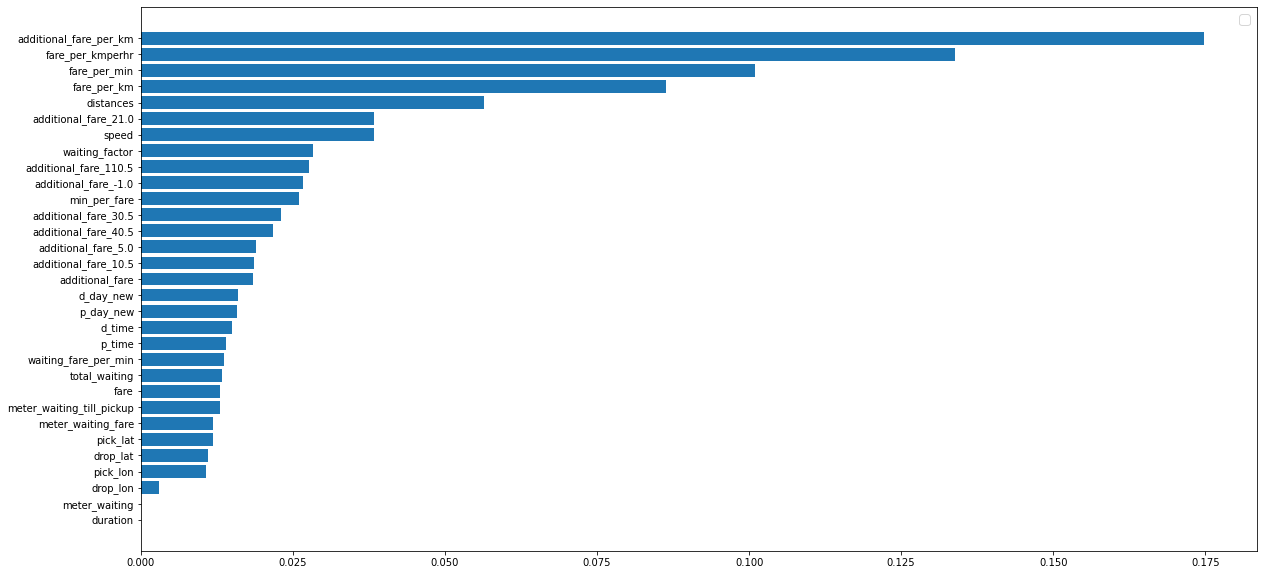

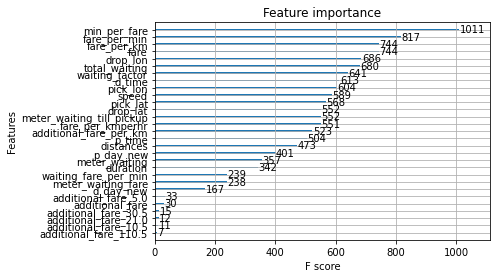

In [ ]:
from matplotlib import pyplot
from xgboost import plot_importance

# feature importance
print(my_model_2.feature_importances_)
# plot
f, ax = pyplot.subplots(figsize=(20,10))
pyplot.barh(td_feature_names, np.sort(my_model_2.feature_importances_))
ax.legend(fontsize = 14)

plot_importance(my_model_2)
pyplot.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

print(f1_score(preds, y_valid, average='macro'))
print("Precision = {}".format(precision_score(y_valid, preds, average='macro')))
print("Recall = {}".format(recall_score(y_valid, preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_valid, preds)))

0.8678224606259167
Precision = 0.9039566061486856
Recall = 0.8389652783124182
Accuracy = 0.9571495109455054


ROC AUC=0.83897


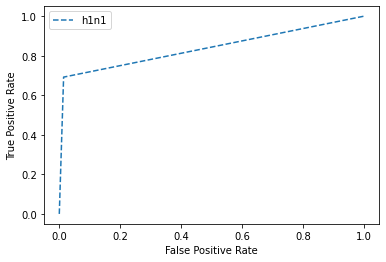

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

roc_auc = roc_auc_score(y_valid, preds)
print('ROC AUC=%.5f' % (roc_auc))

roc_fpr, roc_tpr , _ = roc_curve(y_valid, preds)

pyplot.plot(roc_fpr, roc_tpr, linestyle='--', label='h1n1')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## h2o

In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [ ]:
import h2o

from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 mins 38 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_k1td9m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
dataset=h2o.H2OFrame(td_preprocess)

x_h2o = dataset[td_feature_names]
x=x_h2o.columns
y = "label"

dataset['label'] = dataset['label'].asfactor()
aml = H2OAutoML(max_models=65, seed=1, max_runtime_secs=5000)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
aml.train(x=x, y=y, training_frame=dataset)
lb = aml.leaderboard
lb.head()

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_grid__1_AutoML_20200614_194509_model_22,0.94465,0.132243,0.819433,0.146292,0.185341,0.0343513
XGBoost_grid__1_AutoML_20200614_194509_model_3,0.944591,0.131601,0.820735,0.134456,0.184541,0.0340555
StackedEnsemble_AllModels_AutoML_20200614_194509,0.944586,0.136978,0.826802,0.1328,0.185336,0.0343493
XGBoost_grid__1_AutoML_20200614_194509_model_4,0.944017,0.13779,0.820987,0.146073,0.185781,0.0345147
XGBoost_grid__1_AutoML_20200614_194509_model_13,0.943776,0.139631,0.818344,0.135957,0.186479,0.0347745
XGBoost_grid__1_AutoML_20200614_194509_model_24,0.943607,0.133045,0.817335,0.133349,0.185666,0.0344717
StackedEnsemble_BestOfFamily_AutoML_20200614_194509,0.943151,0.13858,0.822035,0.136868,0.187169,0.0350322
XGBoost_grid__1_AutoML_20200614_194509_model_14,0.942196,0.133891,0.814631,0.142612,0.185309,0.0343395
XGBoost_grid__1_AutoML_20200614_194509_model_5,0.942159,0.135336,0.819305,0.142841,0.184581,0.0340701
XGBoost_grid__1_AutoML_20200614_194509_model_15,0.942064,0.135563,0.812632,0.145547,0.187253,0.0350636


In [ ]:
m = h2o.get_model(aml.leaderboard[0,"model_id"])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


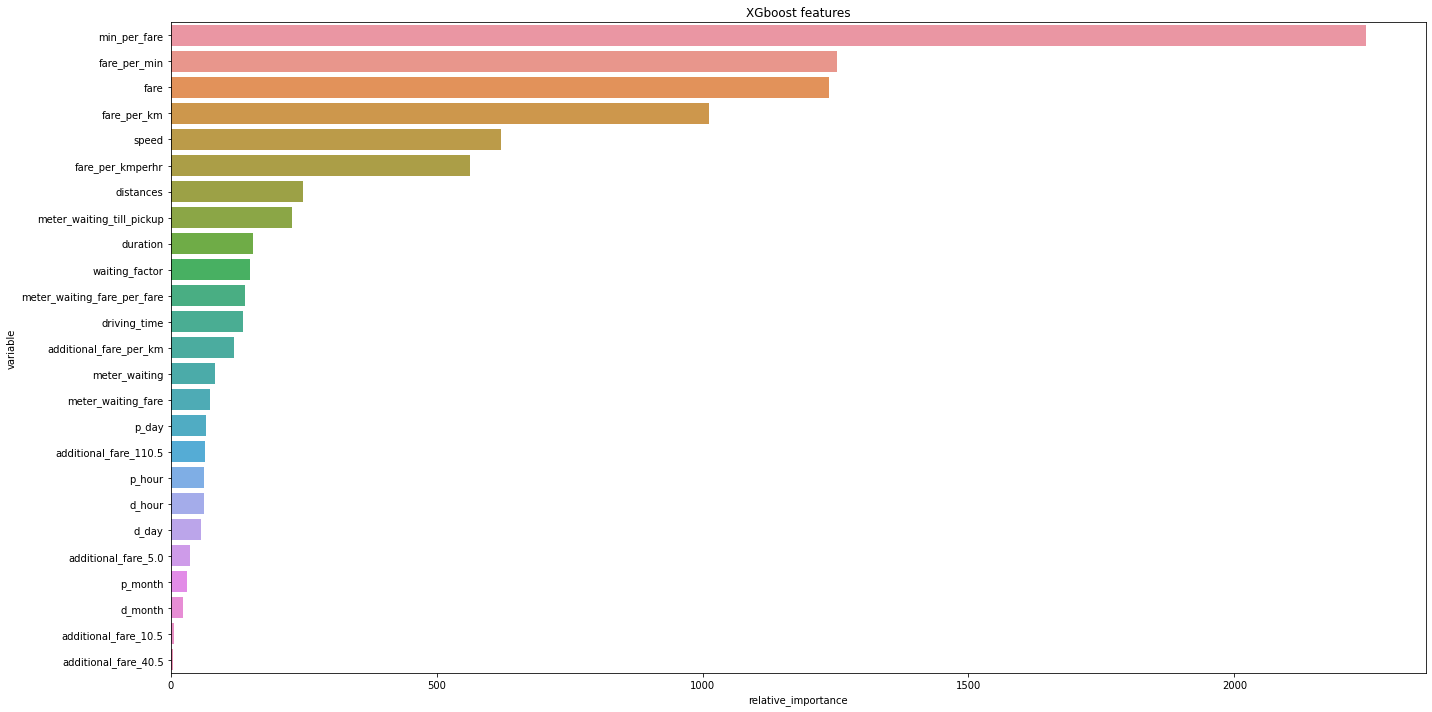

In [ ]:
m = h2o.get_model(aml.leaderboard[0,"model_id"])

feature_imp = m.varimp(use_pandas=True)
x_imp = feature_imp.head(25)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(20, 10))
sns.barplot(x="relative_importance", y="variable", data=x_imp.sort_values(by="relative_importance", ascending=False))
plt.title('XGboost features')
plt.tight_layout()
plt.show()

## Submission

In [ ]:
submission_df = pd.read_csv("/content/drive/My Drive/sem7/ML/sample_submission.csv")
test_features_df = pd.read_csv("/content/drive/My Drive/sem7/ML/test.csv")

In [ ]:
my_model_2.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
date_time_pp = datetimeprocess(test_features_df)
# add_fare_pp = additional_fare_one_hot_top_x(date_time_pp)
calc_dist_pp = calcdistance(date_time_pp)
fare_perkm_pp = fare_per_km(calc_dist_pp)
fare_perkm_pp = additional_fare_one_hot_top_x(fare_perkm_pp)
fillnas(fare_perkm_pp)

X_test = fare_perkm_pp[td_feature_names]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars
/

In [ ]:
pred_hf = h2o.H2OFrame(X_test)

predict = m.predict(pred_hf)

pf = h2o.as_list(predict)

submission_df['prediction'] = pf['predict']

submission_df.head(10)

NameError: ignored

In [ ]:
X_test.columns

Index(['duration', 'meter_waiting', 'drop_lon', 'pick_lon', 'drop_lat',
       'pick_lat', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare',
       'total_waiting', 'waiting_fare_per_min', 'p_time', 'd_time',
       'p_day_new', 'd_day_new', 'additional_fare', 'additional_fare_10.5',
       'additional_fare_5.0', 'additional_fare_40.5', 'additional_fare_30.5',
       'min_per_fare', 'additional_fare_-1.0', 'additional_fare_110.5',
       'waiting_factor', 'speed', 'additional_fare_21.0', 'distances',
       'fare_per_km', 'fare_per_min', 'fare_per_kmperhr',
       'additional_fare_per_km'],
      dtype='object')

In [ ]:
for col in X_test.columns:
  print(col, ':', len(X_test[col].unique()))

duration : 3089
meter_waiting : 1423
drop_lon : 2576
pick_lon : 2440
drop_lat : 7592
pick_lat : 7462
meter_waiting_fare : 2210
meter_waiting_till_pickup : 575
fare : 7461
total_waiting : 1547
waiting_fare_per_min : 1083
p_time : 1143
d_time : 1160
p_day_new : 42
d_day_new : 42
additional_fare : 11
additional_fare_10.5 : 2
additional_fare_5.0 : 2
additional_fare_40.5 : 2
additional_fare_30.5 : 2
min_per_fare : 8436
additional_fare_-1.0 : 1
additional_fare_110.5 : 2
waiting_factor : 4278
speed : 8552
additional_fare_21.0 : 1
distances : 8461
fare_per_km : 8551
fare_per_min : 8463
fare_per_kmperhr : 8469
additional_fare_per_km : 8474


In [ ]:
predictions_final = my_model_2.predict(X_test)

In [ ]:
submission_df['prediction'] = predictions_final
submission_df.head(10)

,tripid,prediction
0,213284604,0
1,213286352,1
2,213293973,0
3,213294622,0
4,213298687,0
5,213299545,1
6,213302332,0
7,213302671,0
8,213305594,0
9,213305134,0


In [ ]:
submission_df.to_csv('/content/drive/My Drive/sem7/ML/submission_28.csv', index=True)

## Handling outliers

In [ ]:
training_data = pd.read_csv("/content/drive/My Drive/sem7/ML/train.csv")


td_feature_names = ['duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 
       'p_hour', 'p_day', 'p_month',  'd_hour', 'd_day',
       'd_month', 'additional_fare_10.5', 'additional_fare_5.0',
       'additional_fare_40.5', 'additional_fare_30.5', 'min_per_fare','km_per_fare',
       'additional_fare_-1.0', 'additional_fare_110.5', 'waiting_factor', 'speed',
       'additional_fare_21.0','distances','fare_per_km','fare_per_min','fare_per_kmperhr','additional_fare_per_km']
boston_df = training_data

boston_df.shape

(17176, 14)

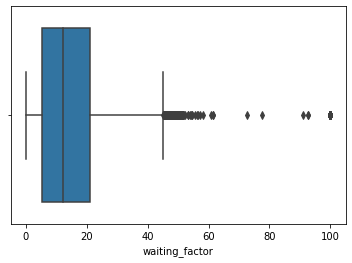

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.boxplot(x=boston_df['waiting_factor'])

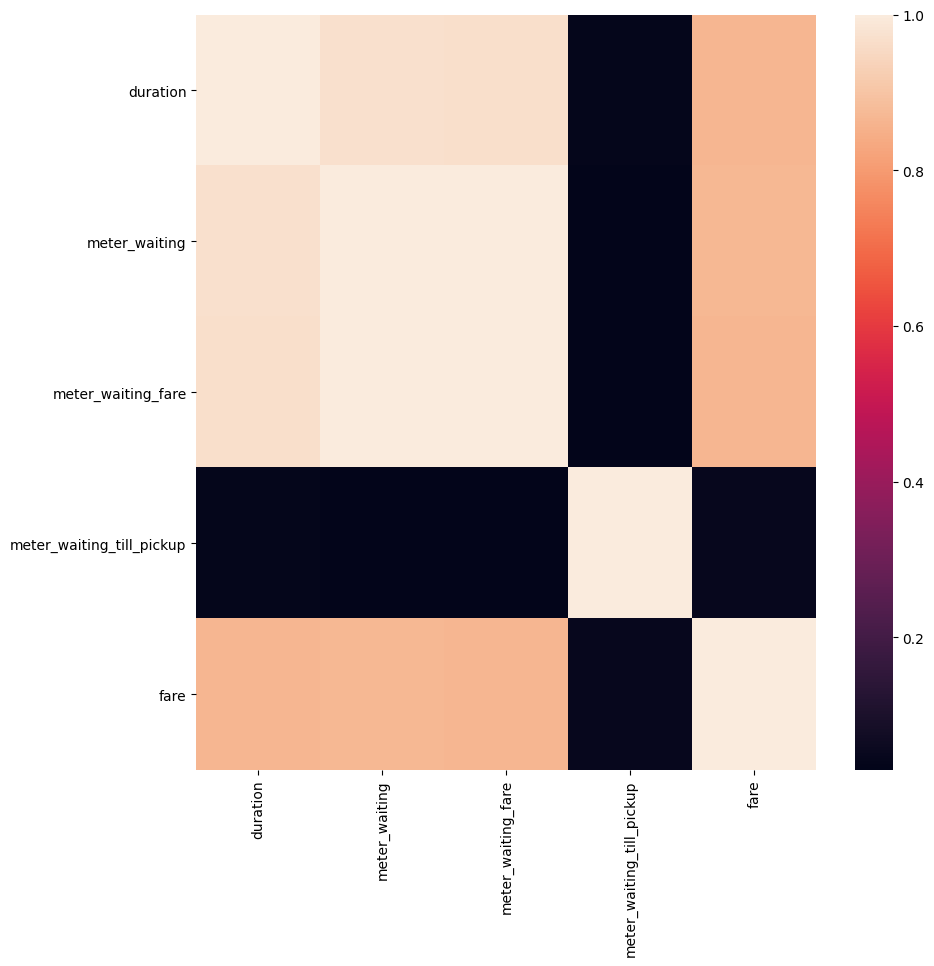

In [ ]:
plt.figure(figsize= (10,10), dpi=100)
sns.heatmap(boston_df.corr())

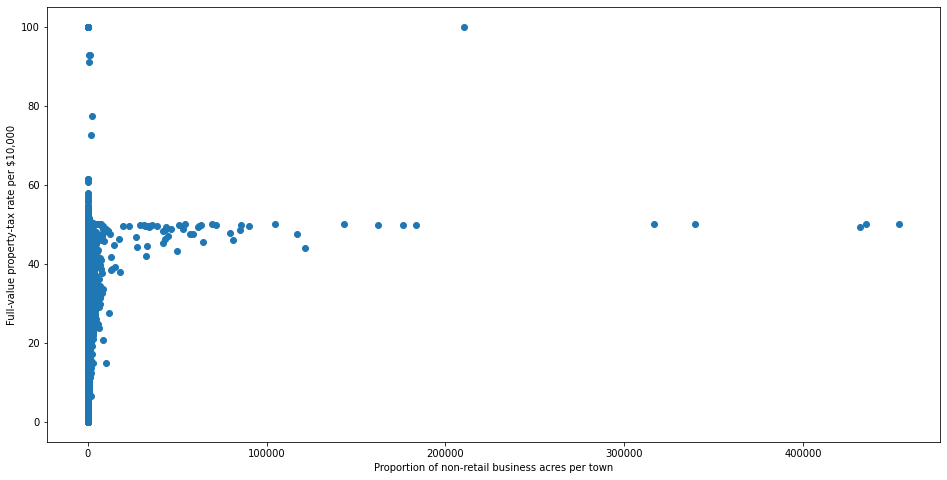

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(boston_df['meter_waiting'], boston_df['waiting_factor'], cmap=td_preprocess['label'])
ax.set_xlabel('Proportion of non-retail business acres per town')
ax.set_ylabel('Full-value property-tax rate per $10,000')
plt.show()

In [ ]:
from scipy import stats
import numpy as np

# boston_df = DataFrameImputer().fit_transform(boston_df)
# boston_df.drop(['pickup_time','drop_time'],axis=1)
boston_df_o = boston_df
boston_df.head()

,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,p_hour,p_day,p_month,d_hour,d_day,d_month,additional_fare_10.5,additional_fare_5.0,additional_fare_40.5,additional_fare_30.5,min_per_fare,km_per_fare,additional_fare_-1.0,additional_fare_110.5,waiting_factor,speed,additional_fare_21.0,distances,fare_per_km,fare_per_min,fare_per_kmperhr,additional_fare_per_km
0,834.0,56.0,0.0000,64.0,270.32,0,1,11,0,1,11,1,0,0,0,2.878070,0.018828,0,0,6.250000,0.389508,0,5.089572,53.112516,20.687755,743.575229,2.063042
1,791.0,47.0,0.0000,134.0,197.85,0,1,11,1,1,11,1,0,0,0,3.760425,0.016002,0,0,5.683192,0.259160,0,3.166069,62.490751,16.195089,812.379761,3.316416
2,1087.0,80.0,0.0000,61.0,301.64,1,1,11,1,1,11,1,0,0,0,3.338417,0.020891,0,0,6.896552,0.378086,0,6.301436,47.868452,18.098400,861.632135,1.666287
3,598.0,271.0,15.6638,68.0,82.30,2,1,11,2,1,11,1,0,0,0,3.973269,0.010467,0,0,31.113662,0.157095,0,0.861405,77.357577,12.152498,773.575772,12.189389
4,-1.0,-1.0,NaN,-1.0,358.39,3,1,11,3,1,11,0,0,0,0,NaN,0.022720,1,0,NaN,NaN,0,8.142667,NaN,NaN,NaN,NaN


In [ ]:
z = np.abs(stats.zscore(td_preprocess['meter_waiting']))
print(z)

[0.07056902 0.07169181 0.06757492 ... 0.07643247 0.06320852 0.07493542]


## Grid search

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=878ad7eaf187fa9b8f0b18fdc773b5724b067e144aef7e92736a606315b39a91
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
#Initializing an XGBClassifier with default parameters and fitting the training data
from xgboost import XGBClassifier
classifier1 = XGBClassifier().fit(X_train, y_train)
#Predicting for training set
train_p1 = classifier1.predict(X_valid)

In [ ]:
# Printing the classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(train_p1, y_valid))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      3976
           1       0.66      0.87      0.75       318

    accuracy                           0.96      4294
   macro avg       0.83      0.92      0.86      4294
weighted avg       0.97      0.96      0.96      4294



In [ ]:
#Importing necessary libraries
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
  params = {'max_depth': int(max_depth),
          'gamma': gamma,
          'n_estimators': int(n_estimators),
          'learning_rate':learning_rate,
          'subsample': 0.8,
          'eta': 0.1,
          'eval_metric': 'rmse'}
  #Cross validating with the specified parameters in 5 folds and 70 iterations
  cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
  #Return the negative RMSE
  return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                             'gamma': (0, 1),
                                             'learning_rate':(0,1),
                                             'n_estimators':(500,4000)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

In [ ]:

#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
classifier2 = XGBClassifier(**params).fit(X_train,y_train)

#predicting for training set
train_p2 = classifier2.predict(X_valid)

#Looking at the classification report
print(classification_report(train_p2, y_valid))

'''{'gamma': 0.3171389900565821, 'learning_rate': 0.18311835358460993, 'max_depth': 5.582478923510351, 'n_estimators': 2232.613518975938}'''

In [ ]:
#Attained prediction accuracy on the training set
cm = confusion_matrix(train_p2, y_valid)
acc = cm.diagonal().sum()/cm.sum()
print(acc)

In [ ]:
param_grid = { 
    'classifier__n_estimators': [200, 500],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [4,5,6,7,8],
    'classifier__criterion' :['gini', 'entropy']}
from sklearn.model_selection import GridSearchCV
CV = GridSearchCV(rf, param_grid, n_jobs= 1)
                  
CV.fit(X_train, y_train)  
print(CV.best_params_)    
print(CV.best_score_)

## Create a pipeline

In [ ]:
numerical_cols = ['tripid', 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare']
categorical_cols = ['pickup_time',
       'drop_time']
       
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
#  Define the model
my_model_1 = XGBClassifier() # Your code here

# Fit the model
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', my_model_1)
                             ])


In [ ]:
training_features = ['tripid', 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pickup_time',
       'drop_time', 'fare']


enc = preprocessing.LabelEncoder()
training_data['label'] = enc.fit_transform(training_data['label'])
X_train_in, X_valid_in, y_train_in, y_valid_in = train_test_split(training_data[training_features], training_data.label, random_state = 0)       

In [ ]:
X_valid_in = X_valid_in[X_train_in.columns]
xgb_pipeline.fit(X_train_in, y_train_in)
preds = xgb_pipeline.predict(X_valid_in)
mean_absolute_error(preds,y_valid_in)

In [ ]:
f1_score(preds, y_valid_in, average='macro')

In [ ]:
my_model_2 =  XGBClassifier(n_estimators=1000,learning_rate=0.05) # Your code here
xgb2_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', my_model_2)
                             ])
# Fit the model
xgb2_pipeline.fit(X_train_in, y_train_in) # Your code here

# Get predictions
predictions_2 = xgb2_pipeline.predict(X_valid_in) # Your code here

# Calculate MAE
mae_2 = mean_absolute_error(predictions_2, y_valid_in) # Your code here

# Uncomment to print MAE
print("Mean Absolute Error:" , mae_2)

In [ ]:
f1_score(predictions_2, y_valid_in, average='macro')
print("Precision = {}".format(precision_score(y_valid_in, predictions_2, average='macro')))
print("Recall = {}".format(recall_score(y_valid_in, predictions_2, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_valid_in, predictions_2)))

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

roc_auc = roc_auc_score(y_valid_in, predictions_2)
print('ROC AUC=%.5f' % (roc_auc))

roc_fpr, roc_tpr , _ = roc_curve(y_valid_in, predictions_2)

pyplot.plot(roc_fpr, roc_tpr, linestyle='--', label='h1n1')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Data visualization

In [ ]:
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
td_preprocess['label'].values

array([0, 0, 0, ..., 0, 0, 0])

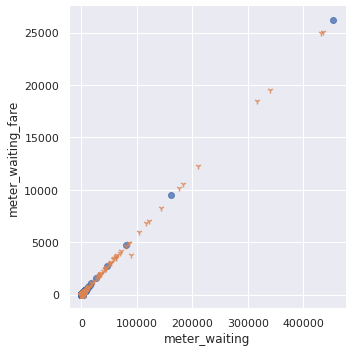

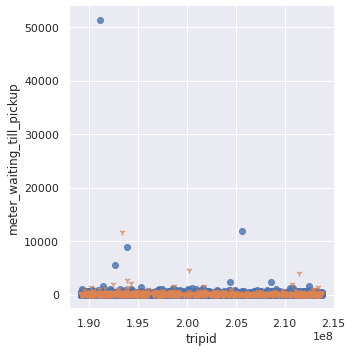

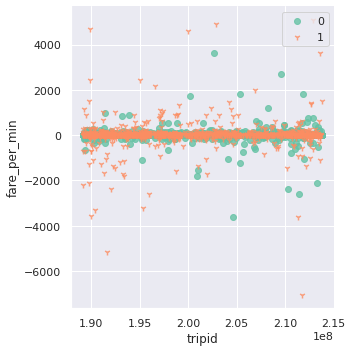

In [ ]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x='meter_waiting', y='meter_waiting_fare', data=td_preprocess, fit_reg=False, hue='label', legend=False, markers=["o", "1"])
sns.lmplot( x='tripid', y='meter_waiting_till_pickup', data=td_preprocess, fit_reg=False, hue='label', legend=False, markers=["o", "1"])
sns.lmplot( x='tripid', y='fare_per_min', data=td_preprocess, fit_reg=False, hue='label', legend=False, markers=["o", "1"], palette="Set2")
  
# Move the legend to an empty part of the plot
plt.legend(loc='upper right')
 
#sns.plt.show()


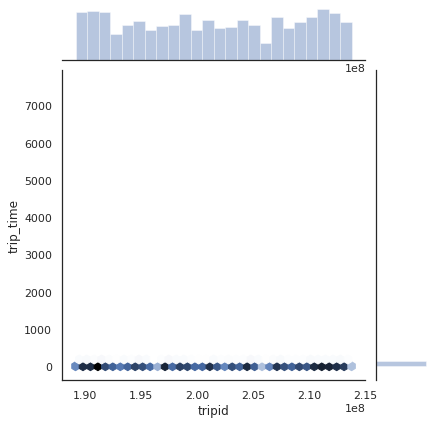

In [ ]:
with sns.axes_style('white'):
    sns.jointplot("tripid", "trip_time", td_preprocess, kind='hex');

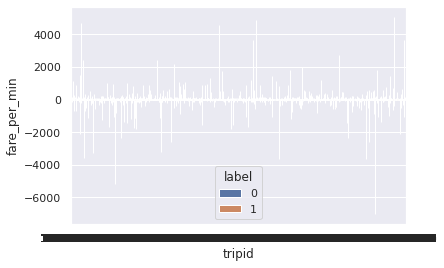

In [ ]:
sns.barplot(x='tripid', y='fare_per_min', data=td_preprocess,hue='label')

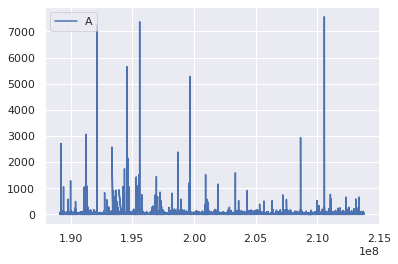

In [ ]:
x = td_preprocess['tripid'].values
y = td_preprocess['trip_time'].values
pyplot.plot(x, y)
pyplot.legend('ABCDEF', ncol=2, loc='upper left');

In [ ]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (td_preprocess[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

In [ ]:
cols_to_plot = ['additional_fare'
]

fig, ax = plt.subplots(
    len(cols_to_plot), figsize=(15,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'label', td_preprocess, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

## lightgbm for regression

### Create train/validation/test splits

In [ ]:
valid_fraction = 0.1
valid_rows = int(len(td_preprocess) * valid_fraction)
train = td_preprocess[:-valid_rows * 2]
valid = td_preprocess[-valid_rows * 2:-valid_rows]
test = td_preprocess[-valid_rows:]

### Train with LightGBM

In [ ]:
feature_cols = ['tripid', 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup','pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare','p_hour', 'p_day', 'p_month', 'p_year', 'd_hour', 'd_day',
       'd_month', 'd_year']

train.columns       

In [ ]:
import lightgbm as lgb

dtrain = lgb.Dataset(train[feature_cols], label=train['encoded_label'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['encoded_label'])
dtest = lgb.Dataset(test[feature_cols], label=test['encoded_label'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10)

In [ ]:
from sklearn import metrics

ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['encoded_label'], ypred)
print(f"Test score: {score}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

print("Precision = {}".format(precision_score(test['encoded_label'], ypred, average='macro')))
print("Recall = {}".format(recall_score(test['encoded_label'], ypred, average='macro')))
print("Accuracy = {}".format(accuracy_score(test['encoded_label'], ypred)))

In [ ]:
td_preprocess.columns

## Alternative method

In [ ]:
!pip install xgboost

In [ ]:
training_data = pd.read_csv("/content/drive/My Drive/sem7/ML/train.csv")
training_feature_names = ['tripid', 'additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'pickup_time','drop_time', 'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare']
enc = preprocessing.LabelEncoder()

for col in training_feature_names:
    training_data[col] = training_data[col].astype('str')
    # test[col] = test[col].astype('str')
    training_data[col] = enc.fit_transform(training_data[col])

training_data['label'] = enc.fit_transform(training_data['label'])
X_train, X_valid, y_train, y_valid = train_test_split(training_data[training_feature_names], training_data.label, random_state = 1)

X = training_data[training_feature_names]
y = training_data.label

In [ ]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train
X_valid_plus = X_valid

# Make new columns indicating what will be imputed
for col in training_feature_names:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

In [ ]:
object_cols = ['pickup_time', 'drop_time']
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(imputed_X_train_plus[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(imputed_X_valid_plus[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = imputed_X_train_plus.index
OH_cols_valid.index = imputed_X_valid_plus.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = imputed_X_train_plus.drop(object_cols, axis=1)
num_X_valid = imputed_X_valid_plus.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [ ]:
OH_cols_valid

In [ ]:
import xgboost as xgb
D_train = xgb.DMatrix(imputed_X_train_plus, label=y_train)
D_test = xgb.DMatrix(imputed_X_valid_plus, label=y_valid)

In [ ]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  

In [ ]:
model = xgb.train(param, D_train, steps)

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_valid, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_valid, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_valid, best_preds)))

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(imputed_X_train_plus, y_train)

## for regressor

In [ ]:
binarizer = preprocessing.Binarizer()
transformer = Binarizer(threshold=0.4).fit(preds.reshape(-1, 1))
# transformer.transform(preds.reshape(-1, 1))

In [ ]:
preds = [x for x in transformer.transform(preds.reshape(-1, 1))]

## binning

In [ ]:
td_preprocess.meter_waiting_fare.value_counts().sort_values(ascending = False)

0.000000      8442
0.583000       100
1.166000        80
1.749000        67
2.332000        47
              ... 
9.210577         1
41.626200        1
79.113100        1
67.744600        1
135.078600       1
Name: meter_waiting_fare, Length: 3733, dtype: int64

In [ ]:
td_preprocess['meter_waiting_fare'].fillna(-1, inplace=True)

In [ ]:
import pandas as pd

bins = [0, 10, 50, 100, 250, 500, 1000]
labels = [1,2,3,4,5,6]
td_preprocess['binned_meter_waiting_fare'] = pd.cut(td_preprocess['meter_waiting_fare'], bins=bins, labels=labels)

In [ ]:
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
est.fit(td_preprocess.meter_waiting_fare.values.reshape(-1, 1))
# td_preprocess.meter_waiting_fare = est.transform(td_preprocess.meter_waiting_fare.reshape(-1, 1))

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='kmeans')

In [ ]:
td_preprocess.meter_waiting_fare.values  = [x for x in transformer.transform(td_preprocess.meter_waiting_fare.values)]

In [ ]:
td_preprocess.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,p_hour,p_day,p_month,p_year,d_hour,d_day,d_month,d_year,additional_fare_10.5,additional_fare_5.0,additional_fare_40.5,additional_fare_60.5,additional_fare_30.5,additional_fare_-1.0,additional_fare_110.5,additional_fare_21.0
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,correct,0,1,11,2019,0,1,11,2019,1,0,0,0,0,0,0,0
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,correct,0,1,11,2019,1,1,11,2019,1,0,0,0,0,0,0,0
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,correct,1,1,11,2019,1,1,11,2019,1,0,0,0,0,0,0,0
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,correct,2,1,11,2019,2,1,11,2019,1,0,0,0,0,0,0,0
4,189128020,-1.0,-1.0,-1.0,-1.0000,-1.0,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,correct,3,1,11,2019,3,1,11,2019,0,0,0,0,0,1,0,0


In [ ]:
td_preprocess.meter_waiting_fare.value_counts().sort_values(ascending = False)